# Importation des librairies

In [37]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# Extraction du dataset

In [38]:
import os
import zipfile
import requests

zip_file = "dataset.zip"
link = "https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip"
dataset_name = "Data_sheep_cat_elephant_with_caption_600"

os.makedirs('./data/dataset/', exist_ok=True)

response = requests.get(link, stream=True)
if response.status_code == 200:
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
else:
    raise Exception(f"Failed to download file. Status code: {response.status_code}")

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("./data/dataset/" + dataset_name)

os.remove(zip_file)
print("Download and extraction complete!")

Download and extraction complete!


# Fonctions

## Chargement du dataset

In [39]:
def load_dataset(seed, height, width, batch_size, data_dir):
    train = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    train_datas = np.concatenate(X_train_list, axis=0)
    train_labels = np.concatenate(y_train_list, axis=0)
    val_datas = np.concatenate(X_test_list, axis=0)
    val_labels = np.concatenate(y_test_list, axis=0)

    numClass = len(train.class_names)
    train_labels = to_categorical(train_labels, num_classes=numClass)
    val_labels = to_categorical(val_labels, num_classes=numClass)

    return train_datas, train_labels, val_datas, val_labels, train.class_names

## Visualisation de loss et d'accuracy

In [40]:
def plot_curves(histories):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    epochs = range(len(histories[0].history['loss']))
    
    train_loss = [history.history['loss'] for history in histories]
    val_loss = [history.history['val_loss'] for history in histories]
    train_acc = [history.history['accuracy'] for history in histories]
    val_acc = [history.history['val_accuracy'] for history in histories]

    mean_loss = np.mean(train_loss, axis=0)
    std_loss = np.std(train_loss, axis=0)
    mean_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)
    mean_acc = np.mean(train_acc, axis=0)
    std_acc = np.std(train_acc, axis=0)
    mean_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    train_color = '#2ca02c'
    val_color = '#9467bd'

    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=train_color, alpha=0.2)
    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color=val_color, alpha=0.2)
    ax2.plot(epochs, mean_acc, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color=train_color, alpha=0.2)
    ax2.plot(epochs, mean_val_acc, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color=val_color, alpha=0.2)
    
    k = len(histories)

    ax1.set_title(f'Loss (k={k})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.set_title(f'Accuracy (k={k})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

## Création du modèle

In [50]:
def create_model(input_shape=(224, 224, 3), num_classes=3, train_base=False):

    base_model = ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    
    base_model.trainable = train_base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Evaluation du modèle

In [51]:
def evaluate_model(dataX, dataY, folds=5, epochs=10, batch_size=32, train_base=False):
    scores, histories = [], []
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    for train_ix, test_ix in kfold.split(dataX):
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        model = create_model(train_base=train_base)

        if any([layer.trainable for layer in model.layers]):
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test, y_test),
                verbose=1
            )
        else:
            history = None

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Fold accuracy: {acc*100:.2f}%')

        scores.append(acc)
        histories.append(history)

    return scores, histories

# Test

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.
Label shape: (1260, 3)
Number of classes: 3
Class names: ['cat', 'elephant', 'sheep']
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - accuracy: 0.7123 - loss: 0.7348 - val_accuracy: 0.9087 - val_loss: 0.2267
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.8730 - loss: 0.3287 - val_accuracy: 0.9246 - val_loss: 0.1934
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.9196 - loss: 0.2582 - val_accuracy: 0.9325 - val_loss: 0.1875
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - accuracy: 0.9296 - loss: 0.1985 - val_accuracy: 0.9365 - val_loss: 0.1549
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step - accuracy: 0.9454 - loss: 0.1485 - val_accuracy: 0.9405 - val_loss: 0.1565
Fold accuracy: 94.05%
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accuracy: 0.6756 - loss: 0.8550 - val_accuracy: 0.861

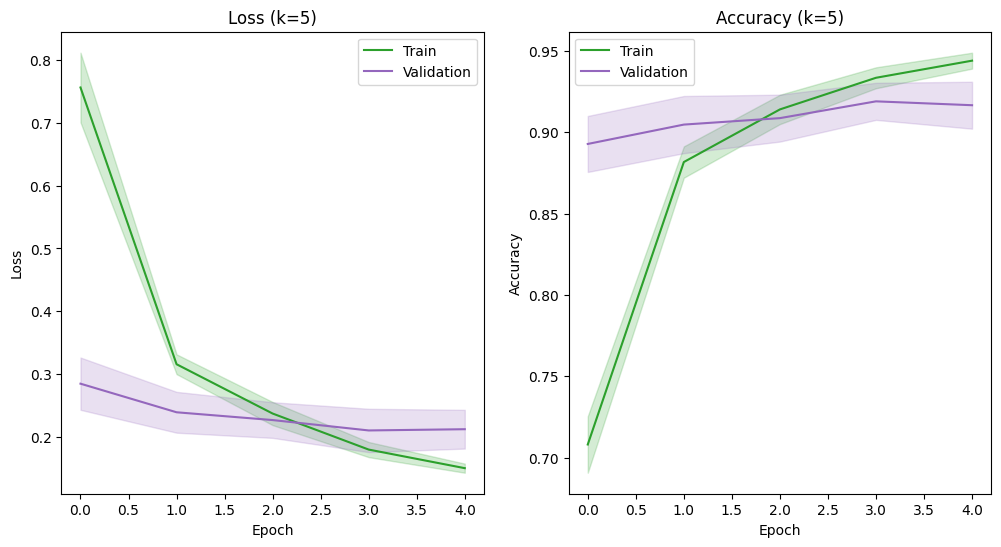

In [52]:
seed = 42
height, width = 224, 224
batch_size = 32
data_dir = "./data/dataset/Data_sheep_cat_elephant_with_caption_600/images"

X_train, y_train, X_val, y_val, classnames = load_dataset(seed, height, width, batch_size, data_dir)
model = create_model(input_shape=(height, width, 3), num_classes=3, train_base=False)
print("Label shape:", y_train.shape)
print("Number of classes:", 3)
print("Class names:", classnames)
scores, histories = evaluate_model(
    dataX=X_train,
    dataY=y_train,
    folds=5,         # 5-fold cross-validation
    epochs=5,        # adjust as needed
    batch_size=batch_size,
    train_base=False # only train top Dense layer
)

plot_curves(histories)